# Finding the Optimal Variable Importance Map
Using Hyper-parameter tuning 

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
from sklearn.model_selection import train_test_split
pd.set_option('display.max_columns', 100)
import matplotlib
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from xgboost import plot_importance
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import RFE
from sklearn.metrics import r2_score
from collections import defaultdict
# from rfpimp import permutation_importances
from sklearn.feature_selection import SelectFromModel
import sklearn.ensemble
from sklearn.metrics import mean_squared_error
from math import sqrt
import xgboost as xgb
import time
import warnings
!pip install lime
import lime #LIME package
import lime.lime_tabular #the type of LIIME analysis we’ll do
import sklearn.ensemble #for building models
from sklearn.model_selection import train_test_split
import random
from sklearn.ensemble import RandomForestRegressor
warnings.filterwarnings('ignore')

     |████████████████████████████████| 276kB 2.8MB/s 
  Created wheel for lime: filename=lime-0.2.0.1-cp36-none-any.whl size=283845 sha256=564da208b2071e1f038899bfab342d6d05f4304d76833bd268fc58d9385cb48f
  Stored in directory: /root/.cache/pip/wheels/4c/4f/a5/0bc765457bd41378bf3ce8d17d7495369d6e7ca3b712c60c89
Successfully built lime


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# df = pd.read_csv("../Data_Jorge/flashiness_modeling_all.csv")
df = pd.read_csv("/content/drive/My Drive/RA/flashiness_modeling_all.csv")
df1 = df[['est_area','rl','rr','si','slopeoutlet', #'gauge',
     'precip','temp',
   'cnbasin','cncell',
   'imperviousbasin','imperviouscell','kfact',
   'ruggedness','rockdepth','rockvolume',
   'activatedBasinPixels',
   'precip_mean','precip_sdev','precip_skew','precip_kurt',
   'flowdist_mean','flowdist_sdev','flowdist_skew','flowdist_kurt',
   'prod_mean','prod_sdev','prod_skew','prod_kurt','G1','G2',
   'delta1','delta2','EcartVertical','EcartHorizontal',
   'snowpercent',
   'bio_1','bio_2','bio_3','bio_4','bio_7','bio_8',
   'bio_10','bio_11','bio_12','bio_15','bio_17','bio_18']] # 'coemcell','bpartexture','lbm',
# df1 = df1.drop(['rockdepth','rockvolume','prod_skew','precip_skew','cncell','delta2'],axis=1)
df1['act_bpixelby_area']=df1['activatedBasinPixels']/df1['est_area']
df1['act_bpixelinto_precipmean']=df1['activatedBasinPixels']*df1['precip_mean']
df1['peakq'] = df['peakq']

## Functions for metric calculations

In [4]:
# from sklearn.metrics import accuracy_score

# Function to plot the lime plots for explaining local model interpretability
def local_feature_imp(X_train,X_test,model):
        # if a feature has 10 or less unique values then treat it as categorical
        categorical_features = np.argwhere(np.array([len(set(X_train.values[:,x]))
        for x in range(X_train.values.shape[1])]) <= 10).flatten()

        # LIME has one explainer for all models
        explainer = lime.lime_tabular.LimeTabularExplainer(X_train.values,
                                 feature_names=X_train.columns.values.tolist(),
                                 class_names=['peakq'],
                                 categorical_features=categorical_features,
                                 verbose=True,
                                 mode='regression')
        # j will be the record we explain
        for i in range(2):
            j = random.randint(0,len(X_test))
            exp = explainer.explain_instance(X_test.values[j], model.predict)
            exp.show_in_notebook(show_table=True)
            fig = exp.as_pyplot_figure();
            
            expXGB = explainer.explain_instance(X_test.values[j], xgb_model.predict, num_features=5)
            expXGB.show_in_notebook(show_table=True) 
            

# function for creating a feature importance dataframe
def imp_df(column_names, importances):
    df = pd.DataFrame({'feature': column_names,
                       'feature_importance': importances}) \
           .sort_values('feature_importance', ascending = False) \
           .reset_index(drop = True)
    return df

# plotting a feature importance dataframe (horizontal barchart)
def var_imp_plot(imp_df, title):
    matplotlib.rcParams['figure.figsize'] = (10,24)
    values = imp_df.sort_values(by='feature_importance',ascending=True)
    plt.barh(values['feature'], values['feature_importance'])
    plt.title(title)
    # plt.tight_layout()
    plt.show()
    
def var_imp_plot_2(imp_df, title,ylabel):
    values = imp_df.sort_values(by='importance',ascending=True)
    values.plot(kind = 'bar', figsize = (24,10))
    plt.xticks(fontsize=19)
    plt.title(title,fontsize=19)
    plt.ylabel(ylabel,fontsize=19)
    plt.show()
    
def run_xgboost(X_train, X_test, y_train, y_test):
    xg = XGBRegressor(objective ='reg:squarederror',
                      max_depth=6,n_estimators=850,
                      learning_rate=0.04,subsample= 0.7,
                      njobs= -1,colsample_bytree = 0.7)
    xg.fit(X_train, y_train)
    metric_train = cal_metrics(xg,X_train,y_train)
    metric_test = cal_metrics(xg,X_test,y_test)
    # print("Training Set \n R^2 value : %f" %xg.score(X_train, y_train), " RMSE value : %f" %rms_train)
    print("\nTraining Set")
    print("R^2 value: %0.2f" %metric_train[0],"\nNash Sutcliffe Efficiency: %0.2f" %metric_train[1],
          "\nMean Relative Error : %0.2f" %metric_train[2],"\nRoot Mean Squared Error : %0.2f" %metric_train[3] )
    print("\nTest Set")
    print("R^2 value: %0.2f" %metric_test[0],"\nNash Sutcliffe Efficiency: %0.2f" %metric_test[1],
          "\nMean Relative Error : %0.2f" %metric_test[2],"\nRoot Mean Squared Error : %0.2f" %metric_test[3] )
    return xg.score(X_test, y_test)

def run_gradientBoost(X_train, X_test, y_train, y_test):
    clf = GradientBoostingRegressor()
    clf.fit(X_train, y_train)
    score = clf.score(X_test,y_test)
    print('Accuracy:',score)
    return score

def get_featureimp_xgboost(model,typ,X_train):
    feature_importance = model.get_booster().get_score(importance_type=typ)
    feature_importance = sorted(feature_importance.items(), key=lambda pair: list(X_train.columns.values).index(pair[0]))
    array_importance = np.array([])
    for i in feature_importance:
        array_importance = np.append(array_importance, i[1])
    # norm = np.linalg.norm(array_importance)
    # array_importance = array_importance/norm
    array_importance = array_importance/np.sum(array_importance)
    array_importance
    feature_importances = pd.DataFrame(array_importance,
                                       index = X_train.columns,
                                        columns=['importance'])
    return(feature_importances)

def get_featureimp (model,X_train):
  feature_importances = pd.DataFrame(model.feature_importances_,index = X_train.columns,
                                    columns=['importance'])
  return(feature_importances)

def cal_bias(model,X_test,y_test): # Mean Relative Error = (Mean of the predictions – mean of testing dataset) / (mean of testing dataset)
    mrm = (np.mean(model.predict(X_test)) - np.mean(y_test))/np.mean(y_test) 
    return mrm

def cal_nash(model,X_test,y_test): # -	Nash Sutcliffe Efficiency
    num = np.sum((model.predict(X_test) - y_test)**2)
    den = np.sum((model.predict(X_test) - np.mean(y_test))**2)
    nse = 1 - (num / den)
    return nse

def cal_r2(model,X_test,y_test): # -	Nash Sutcliffe Efficiency
    num = np.sum((y_test-(model.predict(X_test)))**2)
    den = np.sum((y_test - np.mean(y_test))**2)
    r2 = 1 - (num / den)
    return r2

def cal_rmse(model,X_test,y_test):
    rmse = sqrt(mean_squared_error(y_test, model.predict(X_test)))
    return rmse

def cal_metrics(model,X_test,y_test):
    num = np.sum((y_test-(model.predict(X_test)))**2)
    den = np.sum((y_test - np.mean(y_test))**2)
    r2 = 1 - (num / den)
    num = np.sum((model.predict(X_test) - y_test)**2)
    den = np.sum((model.predict(X_test) - np.mean(y_test))**2)
    nse = 1 - (num / den)
    mrm = (np.mean(model.predict(X_test)) - np.mean(y_test))/np.mean(y_test) 
    rmse = sqrt(mean_squared_error(y_test, model.predict(X_test)))
    return r2,nse,mrm,rmse

def hyper_tune_fast(X,y,n_iter,cv,verbose=False):
  max_depth = list(range(2, 11))
  ntrees = [i * 100 for i in range(1,15)]
  learn_rate = [i * 0.01 for i in range(1, 11)]
  subsample = [i * 0.1 for i in range(1, 11)]
  colsample_bytree = [i * 0.1 for i in range(1, 11)]
  grid_params = [max_depth,ntrees,learn_rate,subsample,colsample_bytree]
  param_name = ['max_depth','ntrees','learn_rate','subsample','colsample_bytree']
  param_list = []
  r2_mean = []
  rmse_mean = []
  for i in range(n_iter):
    c = [random.choice(grid_params[i]) for i in range(len(grid_params))]
    kf = KFold(n_splits=cv)
    kf.get_n_splits(X)
    # print(kf)
    r2_comb = []
    rmse_comb = []  
    for train_index, test_index in kf.split(X):
        # print("TRAIN:", train_index, "VALID:", test_index)
        X_train, X_val = X.iloc[train_index], X.iloc[test_index]
        y_train, y_val = y.iloc[train_index], y.iloc[test_index]
        xg = XGBRegressor(objective = 'reg:squarederror', 
                          tree_method='gpu_hist',
                          max_depth=c[0],n_estimators=c[1],
                              learning_rate=c[2],subsample= c[3],
                              njbobs= -1,colsample_bytree = c[4])
        xg.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_val, y_val)],
                eval_metric='rmse', early_stopping_rounds=20,verbose=False)
        metric_train = cal_metrics(xg,X_train,y_train)
        metric_test = cal_metrics(xg,X_test,y_test)
        r2_comb.append(metric_test[0])
        rmse_comb.append(metric_test[3])
    r2_mean.append(np.asarray(r2_comb).mean())
    rmse_mean.append(np.asarray(rmse_comb).mean())
    param_list.append(c)
  d = {'r2': r2_mean, 'rmse': rmse_mean, 'params':param_list }
  param_df = pd.DataFrame(data=d)
  param_df = param_df.sort_values('rmse')
  res = param_df.iloc[0]
  if verbose==True:
    print('Best params are','\n', param_name,'\n', res['params'],
          "\nwith R^2 value: %0.2f" %res['r2'],
          "\nRoot Mean Squared Error : %0.2f" %res['rmse'])
  return (res)

In [5]:
from typing import Tuple, Dict, List
def gradient(predt: np.ndarray, dtrain: xgb.DMatrix) -> np.ndarray:
    '''Compute the gradient squared log error.'''
    y = dtrain.get_label()
    return (np.log1p(predt) - np.log1p(y)) / (predt + 1)

def hessian(predt: np.ndarray, dtrain: xgb.DMatrix) -> np.ndarray:
    '''Compute the hessian for squared log error.'''
    y = dtrain.get_label()
    return ((-np.log1p(predt) + np.log1p(y) + 1) /
            np.power(predt + 1, 2))

def squared_log(predt: np.ndarray,
                dtrain: xgb.DMatrix) -> Tuple[np.ndarray, np.ndarray]:
    '''Squared Log Error objective. A simplified version for RMSLE used as
    objective function.
    '''
    predt[predt < -1] = -1 + 1e-6
    grad = gradient(predt, dtrain)
    hess = hessian(predt, dtrain)
    return grad, hess

def rmsle(predt: np.ndarray, dtrain: xgb.DMatrix) -> Tuple[str, float]:
    ''' Root mean squared log error metric.'''
    y = dtrain.get_label()
    predt[predt < -1] = -1 + 1e-6
    elements = np.power(np.log1p(y) - np.log1p(predt), 2)
    return 'PyRMSLE', float(np.sqrt(np.sum(elements) / len(y)))

## Tuning parameters


In [6]:
# xgboost Grid Build progress: |████████████████████████████████████████████| 100%
#      col_sample_rate_per_tree learn_rate max_depth ntrees  \
# 0                         0.9       0.09         3    700   
# 1          0.7000000000000001       0.04         8    800   
# 2                         0.4        0.1         7   1400   
# 3         0.30000000000000004       0.08         3   1400   
# 4         0.30000000000000004       0.04         7    800   
# 5                         0.5       0.05         6    900   

#             sample_rate           model_ids                  r2  
# 0                   0.9  gbm_grid2_model_49  0.7232764828344687  
# 1                   0.9   gbm_grid2_model_7  0.7164339165473983  
# 2                   1.0  gbm_grid2_model_16   0.712686381040964  
# 3                   1.0  gbm_grid2_model_17  0.7121512193276867  
# 4                   0.5  gbm_grid2_model_37   0.711307356944432  
# 5                   0.4  gbm_grid2_model_48  0.7109796957336

In [7]:
  # xgboost Grid Build progress: |████████████████████████████████████████████| 100%
#       col_sample_rate_per_tree learn_rate max_depth ntrees  \
# 0                          1.0        0.1         3    600   
# 1                          0.9       0.09         3    500   
# 2                          1.0       0.08         3    900   
# 3                          0.5       0.07         2   1300   
# 4                          1.0       0.04         5    800

#            sample_rate           model_ids                   r2  
# 0                  0.9  gbm_grid2_model_11    0.729925640183185  
# 1   0.7000000000000001  gbm_grid2_model_98   0.7275968681224698  
# 2   0.6000000000000001   gbm_grid2_model_1   0.7231704064201074  
# 3                  0.9  gbm_grid2_model_89    0.719567801579862  
# 4   0.7000000000000001  gbm_grid2_model_55   0.7156049375156646  

In [8]:
params =np.asarray([
[2.0e+00, 1.1e+03, 1.0e-01, 1.0e+00, 2.0e-01],
[5.0e+00, 1.3e+03, 4.0e-02, 9.0e-01, 3.0e-01],
[7.0e+00, 1.2e+03, 3.0e-02, 5.0e-01, 1.0e-01],
[5.0e+00, 1.3e+03, 4.0e-02, 1.0e+00, 2.0e-01],
[1.0e+01, 1.0e+03, 6.0e-02, 7.0e-01, 5.0e-01],
[6.0e+00, 1.0e+03, 2.0e-02, 8.0e-01, 3.0e-01],
[7.0e+00, 1.4e+03, 5.0e-02, 9.0e-01, 2.0e-01],
[6.e+00, 4.e+02, 7.e-02, 9.e-01, 4.e-01],
[9.e+00, 6.e+02, 1.e-01, 9.e-01, 6.e-01],
[7.0e+00, 1.3e+03, 1.0e-02, 9.0e-01, 2.0e-01],
[5.e+00, 6.e+02, 5.e-02, 8.e-01, 1.e-01],
[4.0e+00, 1.2e+03, 4.0e-02, 1.0e+00, 5.0e-01],
[6.0e+00, 1.2e+03, 1.0e-01, 9.0e-01, 1.0e+00],
[6.e+00, 7.e+02, 6.e-02, 9.e-01, 6.e-01],
[7.0e+00, 1.3e+03, 1.0e-02, 6.0e-01, 3.0e-01],
[9.0e+00, 1.2e+03, 1.0e-02, 7.0e-01, 7.0e-01],
[7.e+00, 1.e+03, 2.e-02, 7.e-01, 7.e-01],
[8.0e+00, 1.1e+03, 3.0e-02, 8.0e-01, 3.0e-01],
[6.e+00, 7.e+02, 3.e-02, 1.e+00, 7.e-01],
[6.e+00, 4.e+02, 3.e-02, 1.e+00, 5.e-01],
[5.0e+00, 1.2e+03, 7.0e-02, 1.0e+00, 8.0e-01],
[9.0e+00, 1.2e+03, 1.0e-02, 1.0e+00, 6.0e-01],
[6.0e+00, 1.2e+03, 7.0e-02, 7.0e-01, 2.0e-01],
[5.e+00, 5.e+02, 1.e-01, 9.e-01, 3.e-01],
[5.0e+00, 1.4e+03, 2.0e-02, 6.0e-01, 2.0e-01],
[7.e+00, 4.e+02, 5.e-02, 7.e-01, 3.e-01],
[7.e+00, 7.e+02, 3.e-02, 8.e-01, 2.e-01],
[8.e+00, 6.e+02, 5.e-02, 8.e-01, 2.e-01],
[4.0e+00, 1.2e+03, 2.0e-02, 9.0e-01, 4.0e-01],
[5.0e+00, 1.3e+03, 5.0e-02, 1.0e+00, 6.0e-01],
[7.e+00, 4.e+02, 2.e-02, 1.e+00, 3.e-01],
[9.e+00, 7.e+02, 2.e-02, 6.e-01, 8.e-01],
[6.e+00, 4.e+02, 4.e-02, 8.e-01, 5.e-01],
[1.0e+01, 1.3e+03, 2.0e-02, 1.0e+00, 1.0e-01],
[7.e+00, 9.e+02, 8.e-02, 1.e+00, 5.e-01],
[9.e+00, 6.e+02 ,1.e-02, 1.e+00, 2.e-01],
[9.0e+00, 1.4e+03, 9.0e-02, 1.0e+00, 3.0e-01],
[5.e+00, 3.e+02, 6.e-02, 7.e-01, 2.e-01],
[5.e+00, 5.e+02, 7.e-02, 8.e-01, 4.e-01],
[9.e+00, 7.e+02, 2.e-02, 8.e-01, 2.e-01]])

## Single XgboostRegressor Model (using GPU)

In [86]:
params[30]

array([7.e+00, 4.e+02, 2.e-02, 1.e+00, 3.e-01])

In [12]:
df1_trans = df1.sample(frac=1,random_state = 1)
x=df1_trans.loc[:, df1_trans.columns != 'peakq']
y=df1_trans['peakq'] #'reg:squarederror'

bins = np.linspace(np.floor(min(y)),np.ceil(max(y)), 5) # 5 bins for untransformed and 50 for transformed
# Save your Y values in a new ndarray, broken down by the bins created above.
y_binned = np.digitize(y, bins)
# Pass y_binned to the stratify argument,and sklearn will handle the rest
from sklearn.model_selection import RandomizedSearchCV# Number of trees in random forest
X_train, X_test, y_train, y_test = train_test_split(x,y, test_size = 0.15, random_state = 13,stratify=y_binned)
bins = np.linspace(np.floor(min(y_train)),np.ceil(max(y_train)), 5) # 5 bins for untransformed and 50 for transformed
y_binned = np.digitize(y_train, bins)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.15, random_state = 13,stratify=y_binned)

start_time = time.time()
# xg = XGBRegressor(objective = 'reg:squarederror', 
#                   tree_method='gpu_hist',
#                    max_depth=6,n_estimators=850,
#                        learning_rate=0.04,subsample= 0.8,
#                        njobs= -1,colsample_bytree = 0.9)
c = params[30]
xg = XGBRegressor(objective = 'reg:squarederror',
                  tree_method='gpu_hist',
                  max_depth=c[0].astype(int),n_estimators=c[1].astype(int),
                  learning_rate=c[2],subsample=c[3],
                  njobs= -1,colsample_bytree = c[4])

xg.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_val, y_val)],
        eval_metric='rmse', early_stopping_rounds=20,verbose=False)
metric_train = cal_metrics(xg,X_train,y_train)
metric_test = cal_metrics(xg,X_test,y_test)
print("Using XGboost(All variables)")
# print("Training Set \n R^2 value : %f" %xg.score(X_train, y_train), " RMSE value : %f" %rms_train)
print("\nTraining Set")
print("R^2 value: %0.2f" %metric_train[0],"\nNash Sutcliffe Efficiency: %0.2f" %metric_train[1],
      "\nMean Relative Error : %0.2f" %metric_train[2],"\nRoot Mean Squared Error : %0.2f" %metric_train[3] )
print("\nTest Set")
print("R^2 value: %0.2f" %metric_test[0],"\nNash Sutcliffe Efficiency: %0.2f" %metric_test[1],
      "\nMean Relative Error : %0.2f" %metric_test[2],"\nRoot Mean Squared Error : %0.2f" %metric_test[3] )
print("\n--- %s seconds ---" % (time.time() - start_time))

Using XGboost(All variables)

Training Set
R^2 value: 0.89 
Nash Sutcliffe Efficiency: 0.86 
Mean Relative Error : -0.00 
Root Mean Squared Error : 116.93

Test Set
R^2 value: 0.76 
Nash Sutcliffe Efficiency: 0.69 
Mean Relative Error : 0.02 
Root Mean Squared Error : 158.20

--- 9.466662406921387 seconds ---


In [14]:
import numpy as np
from sklearn.model_selection import KFold
df1_trans = df1.sample(frac=1,random_state = 1)
x=df1_trans.loc[:, df1_trans.columns != 'peakq']
y=df1_trans['peakq'] #'reg:squarederror'

bins = np.linspace(np.floor(min(y)),np.ceil(max(y)), 5) # 5 bins for untransformed and 50 for transformed
# Save your Y values in a new ndarray, broken down by the bins created above.
y_binned = np.digitize(y, bins)
# Pass y_binned to the stratify argument,and sklearn will handle the rest
from sklearn.model_selection import RandomizedSearchCV# Number of trees in random forest
X_train_main, X_test_main, y_train_main, y_test_main = train_test_split(x,y, test_size = 0.15, random_state = 13,stratify=y_binned)
bins = np.linspace(np.floor(min(y_train)),np.ceil(max(y_train)), 5) # 5 bins for untransformed and 50 for transformed
y_binned = np.digitize(y_train_main, bins)
X_train, X_test, y_train, y_test = train_test_split(X_train_main, y_train_main, test_size=0.15, random_state = 13,stratify=y_binned)
X = X_train
y = y_train
start_time = time.time()
result = hyper_tune_fast(X,y,n_iter=3,cv=4)
print("\n--- %s seconds ---" % (time.time() - start_time))
c = result['params']


--- 34.78761959075928 seconds ---


In [16]:
result['params']

[9, 600, 0.02, 1.0, 0.9]

## Hyper-Param tuning with Sampling Experiment

In [19]:
# !unzip "/content/40_run_data.zip" -d "/content/40_run_data/" 
import pandas as pd
x = pd.read_csv(('/content/40_run_data/content/all_data/Parameter_tuning.csv'))
x['Hyper_params'][0]

In [58]:
import numpy as np
from sklearn.model_selection import KFold
df1_trans = df1.sample(frac=1,random_state = 1)
x=df1_trans.loc[:, df1_trans.columns != 'peakq']
y=df1_trans['peakq'] #'reg:squarederror'

bins = np.linspace(np.floor(min(y)),np.ceil(max(y)), 5) # 5 bins for untransformed and 50 for transformed
# Save your Y values in a new ndarray, broken down by the bins created above.
y_binned = np.digitize(y, bins)
# Pass y_binned to the stratify argument,and sklearn will handle the rest
from sklearn.model_selection import RandomizedSearchCV# Number of trees in random forest
X_train_main, X_test_main, y_train_main, y_test_main = train_test_split(x,y, test_size = 0.15, random_state = 13,stratify=y_binned)
bins = np.linspace(np.floor(min(y_train)),np.ceil(max(y_train)), 5) # 5 bins for untransformed and 50 for transformed
y_binned = np.digitize(y_train_main, bins)

In [77]:
all_mean_train = []
all_mean_test = []
all_par_mean_train = []
all_par_mean_test = []
all_feature_importance = []
all_main_features = []
all_params = []
main_features_score = []
len_param = 40
start_time = time.time()
for i in range(len_param):
  X_train, X_test, y_train, y_test = train_test_split(X_train_main, y_train_main, test_size=0.15, random_state = i,stratify=y_binned)
  X = X_train
  y = y_train
  result = hyper_tune_fast(X,y,n_iter=50,cv=4)
  c = result['params']
  # c = params[i]
  # Main model trained
  xg = XGBRegressor(objective = 'reg:squarederror',
                    tree_method='gpu_hist',
                    max_depth=c[0].astype(int),n_estimators=c[1].astype(int),
                    learning_rate=c[2],subsample=c[3],
                    njobs= -1,colsample_bytree = c[4])
  xg.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)],
        eval_metric='rmse', early_stopping_rounds=20,verbose=False)
  metric_train = cal_metrics(xg,X_train,y_train)
  metric_test = cal_metrics(xg,X_test,y_test)
  all_mean_train.append(metric_train)
  all_mean_test.append(metric_test)
  # Variable Importance Measured
  feature_importances = get_featureimp(xg,X_train) #total_gain
  all_feature_importance.append(feature_importances)
  gain_support = (feature_importances['importance']>(feature_importances['importance'].mean())).values
  support_feature = X_train.loc[:,gain_support].columns.tolist()
  all_main_features.append(support_feature)
  values = feature_importances.loc[support_feature,:].sort_values(by='importance',ascending=False)
  main_features_score.append(values)
  xg_df = df1_trans[support_feature]
  #performance on parsimonous model
  X_important_train1 = X_train[support_feature]
  X_important_val1 = X_val[support_feature]
  X_important_test1 = X_test[support_feature]
  xg_imp = XGBRegressor(objective = 'reg:squarederror',
                    tree_method='gpu_hist',
                    max_depth=c[0].astype(int),n_estimators=c[1].astype(int),
                    learning_rate=c[2],subsample=c[3],
                    njobs= -1,colsample_bytree = c[4])
  # xg_imp.fit(X_important_train1,y_train) #Fitting the data to model
  xg_imp.fit(X_important_train1, y_train, eval_set=[(X_important_train1, y_train),
                                                    (X_important_val1, y_val)],
        eval_metric='rmse', early_stopping_rounds=20,verbose=False)
  metric_train = cal_metrics(xg_imp,X_important_train1,y_train)
  metric_test = cal_metrics(xg_imp,X_important_test1,y_test)
  all_par_mean_train.append(metric_train)
  all_par_mean_test.append(metric_test)
  all_params.append(c)

print("\n--- %s seconds ---" % (time.time() - start_time))
all_mean_train = np.asarray(all_mean_train)
all_mean_test = np.asarray(all_mean_test)
all_par_mean_train = np.asarray(all_par_mean_train)
all_par_mean_test = np.asarray(all_par_mean_test)
all_params = np.asarray(all_params)


# intialise data of lists.
x = np.asarray([main_features_score[i].values.sum() for i in range(len_param)])
y = np.asarray([all_feature_importance[i].values.sum() for i in range(len_param)])
a = all_mean_train[:,0]
b = all_mean_test[:,0]
c = all_par_mean_train[:,0]
d = all_par_mean_test[:,0]
precip_mom = ['flowdist_sdev','precip_mean','act_bpixelinto_precipmean',
              'flowdist_mean','prod_mean','precip_sdev','prod_sdev','precip_skew']
e = np.asarray(precip_mom)
precip = []
for i in range (len_param):
  temp = np.asarray(all_main_features[i])
  precip.append((np.in1d(e,temp)).astype(int).sum())

data = {'Train_R2':all_mean_train[:,0],'Test_R2':all_mean_test[:,0],
        'Train_test_%_loss': ((a-b)/a)*100,
        'Num_of_var':[len(list) for list in all_main_features ],
        '%_of_imp_thru_selected_var': x/y,
        'No.of_precip_mom': precip,
        'Par_Train_R2':all_par_mean_train[:,0],'Par_Test_R2':all_par_mean_test[:,0],
        'Par_Train_test_%_loss': ((c-d)/c)*100,
        # 'Total_imp_score_selected': [main_features_score[i].values.sum() for i in range(len_param)],
        # 'Total_imp_score_allvar': [all_feature_importance[i].values.sum() for i in range(len_param)],
        'Var_selected':[list(main_features_score[i].index) for i in range(len_param)],
        'Imp_scores(corr)':[list(main_features_score[i].values) for i in range(len_param)],
        'Hyper_params': list(all_params)
        } 

# Create DataFrame 
df_left = pd.DataFrame(data) 

  
# Print the output. 
df_left.head()
import itertools
unique_var = list(set(list(itertools.chain.from_iterable(all_main_features))))
x = np.asarray(unique_var)
data = []
for i in range (len_param):
  y = np.asarray(all_main_features[i])
  data.append((np.in1d(x,y)).astype(int))

# Create the pandas DataFrame 
df_right = pd.DataFrame(data, columns = unique_var) 

# print dataframe. 
# df_right.head()
df3 = df_left.join(df_right)
# df3.head()
df3.to_csv('Parameter_tuning.csv')
# Ranking the order for important variables
ranking = df_right.sum().sort_values(ascending=False)
ranking.to_csv('Variable_rank.csv')

#Get unique variables across all permutations:
import itertools
unique_var = list(set(list(itertools.chain.from_iterable(all_main_features))))
merged_df = pd.concat(main_features_score)
x = np.asarray(unique_var)
for i in x:
  result = (merged_df.loc[i].count())
  if ((isinstance(result, pd.Series) != True)):
    unique_var.remove(i)
x = np.asarray(unique_var)
data = []
for i in x:
  # small = []
  data.append(merged_df.loc[i].mean().values)
  data.append(merged_df.loc[i].sum().values)
  data.append(merged_df.loc[i].count().values)
  # data.append(np.asarray(small))
data = np.reshape(data, (-1, 3))
# Create the pandas DataFrame 
df_rank = pd.DataFrame(np.transpose(data), columns = unique_var) 
data = (df_rank.transpose())
ranking_pd = pd.DataFrame(data) 
# ranking_pd = ranking_pd.drop(['Unnamed: 0'])
ranking_pd = ranking_pd.rename(columns={0: "Mean", 1: "Sum", 2: "Count"})
df_rank = ranking_pd.sort_values('Sum',ascending=0)
# print dataframe. 
# df_rank.head()
df_rank.to_csv('Var_rank_stats.csv')
!mkdir all_data
df3.to_csv('all_data/Parameter_tuning.csv')
ranking.to_csv('all_data/Variable_rank.csv')
df_rank.to_csv('all_data/Var_rank_stats.csv')
!zip -r "/content/all_data.zip" "/content/all_data/"
from google.colab import files
files.download('all_data.zip')


--- 489.71732234954834 seconds ---
updating: content/all_data/ (stored 0%)
updating: content/all_data/Var_rank_stats.csv (deflated 47%)
updating: content/all_data/Variable_rank.csv (deflated 41%)
updating: content/all_data/Parameter_tuning.csv (deflated 79%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [13]:
df_x = pd.read_csv('/content/Parameter_tuning.csv')

In [17]:
df_x['Var_selected'][30]

"['est_area', 'G2', 'G1', 'rl', 'ruggedness', 'slopeoutlet', 'act_bpixelinto_precipmean', 'rockvolume', 'activatedBasinPixels', 'bio_10', 'rr', 'bio_15', 'snowpercent', 'prod_mean', 'temp', 'flowdist_mean']"

In [ ]:
# Seaborn uses Freedman-Diaconis rule to calculate bin width if bins parameter is not specified in the function seaborn.distplot()
obs = 13
x = [df_x['Train_R2']]
y = [all_data[i]['Test_R2'][obs] for i in range(len(all_data))]
sns.distplot(x,label='Train_R2')
sns.distplot(y,label='Test_R2',)
plt.axvline(np.median(x), 0,0.9)
plt.axvline(np.median(y), 0,0.9, color=sns.color_palette("tab10")[1])
plt.legend()

## Hyperparameter Tuning and Old

In [ ]:
n_estimators = [1200,1400,1200,1400,1400,1000,1400,1400,1400,800,850,1400,900,
                900,1200,1100,1400,800,900,700,600,850,600,500,900,1300,800,700,
                800,1400,1400,800,900,1400,600, 1200,850]
max_depth = [4,3,3,3,3,3,3,3,3,5,5,3,5,4,4,10,3,7,3,10,10,6,3,3,3,2,5,3,8,7,3,7,
             6,3,10,9,6]
learning_rate = [0.08, 0.08, 0.04, 0.08, 0.08, 0.08, 0.08, 0.08, 0.08, 0.05,
                 0.04, 0.08, 0.05, 0.05, 0.05, 0.01, 0.1, 0.04, 0.08,
                 0.04, 0.09, 0.04, 0.1, 0.09, 0.08, 0.07, 0.04, 0.09, 0.04,
                 0.1, 0.08, 0.04, 0.05, 0.08, 0.05, 0.04,0.04]
subsample= [0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.9, 0.8, 0.8, 0.9, 0.7, 0.8, 0.8,
            0.8, 0.8, 0.9, 0.6, 0.5, 0.6, 0.6, 0.6, 0.7, 0.9, 0.7, 0.6, 0.9, 0.7,
            0.9, 0.9, 1, 1, 0.5, 0.4, 0.8, 0.9, 0.9,0.08]
colsample_bytree = [0.6, 0.6, 0.4, 0.3, 0.4, 0.3, 0.3, 0.4, 0.5, 0.5, 0.5,
                    0.5, 0.4, 0.4, 0.4, 0.1, 0.2, 0.3, 1, 0.3, 0.5, 0.4, 1,0.9, 1,
                    0.5, 1, 0.9, 0.7, 0.4, 0.3, 0.3, 0.5, 0.3, 0.1, 0.1, 0.9]
param_grid = [n_estimators, max_depth, learning_rate, subsample, colsample_bytree]
len_param = len(n_estimators)
[len(i) for i in param_grid]

[37, 37, 37, 37, 37]

In [ ]:
df1_trans = df1.sample(frac=1,random_state = 1)
x=df1_trans.loc[:, df1_trans.columns != 'peakq']
y=df1_trans['peakq'] #'reg:squarederror'

bins = np.linspace(np.floor(min(y)),np.ceil(max(y)), 5) # 5 bins for untransformed and 50 for transformed
# Save your Y values in a new ndarray, broken down by the bins created above.
y_binned = np.digitize(y, bins)
# Pass y_binned to the stratify argument,and sklearn will handle the rest
from sklearn.model_selection import RandomizedSearchCV# Number of trees in random forest



X_train, X_test, y_train, y_test = train_test_split(x,y, test_size = 0.2, random_state = 13,stratify=y_binned)
bins = np.linspace(np.floor(min(y_train)),np.ceil(max(y_train)), 5) # 5 bins for untransformed and 50 for transformed
y_binned = np.digitize(y_train, bins)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state = 13,stratify=y_binned)

In [ ]:
all_mean_train = []
all_mean_test = []
all_par_mean_train = []
all_par_mean_test = []
all_feature_importance = []
all_main_features = []
main_features_score = []
start_time = time.time()
for i in range(len_param):
  # Main model trained
  xg = XGBRegressor(objective = 'reg:squarederror',
                    tree_method='gpu_hist',
                    n_estimators=param_grid[0][i],max_depth=param_grid[1][i],
                    learning_rate=param_grid[2][i],subsample=param_grid[3][i],
                    njobs= -1,colsample_bytree = param_grid[4][i])
  xg.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_val, y_val)],
        eval_metric='rmse', early_stopping_rounds=20,verbose=False)
  metric_train = cal_metrics(xg,X_train,y_train)
  metric_test = cal_metrics(xg,X_test,y_test)
  all_mean_train.append(metric_train)
  all_mean_test.append(metric_test)
  # Variable Importance Measured
  feature_importances = get_featureimp_xgboost(xg,'total_gain',X_train)
  all_feature_importance.append(feature_importances)
  gain_support = (feature_importances['importance']>(feature_importances['importance'].mean())).values
  support_feature = X_train.loc[:,gain_support].columns.tolist()
  all_main_features.append(support_feature)
  values = feature_importances.loc[support_feature,:].sort_values(by='importance',ascending=False)
  main_features_score.append(values)
  xg_df = df1_trans[support_feature]
  #performance on parsimonous model
  X_important_train1 = X_train[support_feature]
  X_important_val1 = X_val[support_feature]
  X_important_test1 = X_test[support_feature]
  xg_imp = XGBRegressor(objective = 'reg:squarederror',
                    tree_method='gpu_hist',
                    n_estimators=param_grid[0][i],max_depth=param_grid[1][i],
                    learning_rate=param_grid[2][i],subsample=param_grid[3][i],
                    njobs= -1,colsample_bytree = param_grid[4][i])
  # xg_imp.fit(X_important_train1,y_train) #Fitting the data to model
  xg_imp.fit(X_important_train1, y_train, eval_set=[(X_important_train1, y_train),
                                                    (X_important_val1, y_val)],
        eval_metric='rmse', early_stopping_rounds=20,verbose=False)
  metric_train = cal_metrics(xg_imp,X_important_train1,y_train)
  metric_test = cal_metrics(xg_imp,X_important_test1,y_test)
  all_par_mean_train.append(metric_train)
  all_par_mean_test.append(metric_test)

print("\n--- %s seconds ---" % (time.time() - start_time))
all_mean_train = np.asarray(all_mean_train)
all_mean_test = np.asarray(all_mean_test)
all_par_mean_train = np.asarray(all_par_mean_train)
all_par_mean_test = np.asarray(all_par_mean_test)



--- 205.57462239265442 seconds ---


In [ ]:
# intialise data of lists.
len_param = 4
x = np.asarray([main_features_score[i].values.sum() for i in range(len_param)])
y = np.asarray([all_feature_importance[i].values.sum() for i in range(len_param)])
a = all_mean_train[:,0]
b = all_mean_test[:,0]
c = all_par_mean_train[:,0]
d = all_par_mean_test[:,0]
precip_mom = ['flowdist_sdev','precip_mean','act_bpixelinto_precipmean',
              'flowdist_mean','prod_mean','precip_sdev','prod_sdev','precip_skew']
e = np.asarray(precip_mom)
precip = []
for i in range (len_param):
  temp = np.asarray(all_main_features[i])
  precip.append((np.in1d(e,temp)).astype(int).sum())

data = {'Train_R2':all_mean_train[:,0],'Test_R2':all_mean_test[:,0],
        'Train_test_%_loss': ((a-b)/a)*100,
        'Num_of_var':[len(list) for list in all_main_features ],
        '%_of_imp_thru_selected_var': x/y,
        'No.of_precip_mom': precip,
        'Par_Train_R2':all_par_mean_train[:,0],'Par_Test_R2':all_par_mean_test[:,0],
        'Par_Train_test_%_loss': ((c-d)/c)*100,
        # 'Total_imp_score_selected': [main_features_score[i].values.sum() for i in range(len_param)],
        # 'Total_imp_score_allvar': [all_feature_importance[i].values.sum() for i in range(len_param)],
        'Var_selected':[list(main_features_score[i].index) for i in range(len_param)],
        'Imp_scores(corr)':[list(main_features_score[i].values) for i in range(len_param)],
        # 'Hyper_params': list(all_params)
        } 

# Create DataFrame 
df_left = pd.DataFrame(data) 

  
# Print the output. 
df_left.head()

,Train_R2,Test_R2,Train_test_%_loss,Num_of_var,%_of_imp_thru_selected_var,No.of_precip_mom,Par_Train_R2,Par_Test_R2,Par_Train_test_%_loss,Var_selected,Imp_scores(corr),Hyper_params
0,0.819096,0.677228,17.320133,8,0.697469,1,0.841395,0.624920,25.728088,"[est_area, rl, slopeoutlet, act_bpixelinto_pre...","[[0.7989080672736434], [0.3272773547394039], [...","[4.0, 800.0, 0.08, 0.9, 0.7000000000000001]"
1,0.861043,0.740494,14.000410,16,0.593315,6,0.956184,0.753622,21.184392,"[est_area, activatedBasinPixels, rl, act_bpixe...","[[0.4678618583466632], [0.30124997899654904], ...","[6.0, 1100.0, 0.08, 0.30000000000000004, 0.300..."
2,0.881561,0.704916,20.037821,9,0.648144,1,0.851004,0.719346,15.470921,"[est_area, slopeoutlet, rl, act_bpixelinto_pre...","[[0.8047805439843015], [0.3039207407265542], [...","[6.0, 600.0, 0.03, 1.0, 0.6000000000000001]"
3,0.868369,0.716798,17.454673,8,0.730536,1,0.888239,0.723390,18.559063,"[est_area, slopeoutlet, act_bpixelinto_precipm...","[[0.9083853696545955], [0.2689169750218152], [...","[5.0, 1400.0, 0.04, 1.0, 1.0]"


In [ ]:
#Get unique variables across all permutations:
import itertools
unique_var = list(set(list(itertools.chain.from_iterable(all_main_features))))
x = np.asarray(unique_var)
data = []
for i in range (len_param):
  y = np.asarray(all_main_features[i])
  data.append((np.in1d(x,y)).astype(int))
# Create the pandas DataFrame 
df_right = pd.DataFrame(data, columns = unique_var) 

# print dataframe. 
df_right.head()

,rockdepth,flowdist_mean,est_area,ruggedness,G2,G1,rl,bio_10,si,prod_mean,precip_mean,rockvolume,activatedBasinPixels,rr,imperviousbasin,precip_sdev,act_bpixelinto_precipmean,bio_15,slopeoutlet,precip,prod_sdev
0,1,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,1,1,0
1,0,1,1,1,0,1,1,0,0,1,1,1,1,1,1,1,1,1,1,0,1
2,0,0,1,1,1,0,1,1,0,0,0,0,0,1,0,0,1,0,1,1,0
3,1,0,1,1,0,0,0,0,1,0,0,1,0,0,0,0,1,0,1,1,0


In [ ]:
df3 = df_left.join(df_right)
df3.head()

,Train_R2,Test_R2,Train_test_%_loss,Num_of_var,%_of_imp_thru_selected_var,No.of_precip_mom,Par_Train_R2,Par_Test_R2,Par_Train_test_%_loss,Var_selected,Imp_scores(corr),Hyper_params,rockdepth,flowdist_mean,est_area,ruggedness,G2,G1,rl,bio_10,si,prod_mean,precip_mean,rockvolume,activatedBasinPixels,rr,imperviousbasin,precip_sdev,act_bpixelinto_precipmean,bio_15,slopeoutlet,precip,prod_sdev
0,0.819096,0.677228,17.320133,8,0.697469,1,0.841395,0.624920,25.728088,"[est_area, rl, slopeoutlet, act_bpixelinto_pre...","[[0.7989080672736434], [0.3272773547394039], [...","[4.0, 800.0, 0.08, 0.9, 0.7000000000000001]",1,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,1,1,0
1,0.861043,0.740494,14.000410,16,0.593315,6,0.956184,0.753622,21.184392,"[est_area, activatedBasinPixels, rl, act_bpixe...","[[0.4678618583466632], [0.30124997899654904], ...","[6.0, 1100.0, 0.08, 0.30000000000000004, 0.300...",0,1,1,1,0,1,1,0,0,1,1,1,1,1,1,1,1,1,1,0,1
2,0.881561,0.704916,20.037821,9,0.648144,1,0.851004,0.719346,15.470921,"[est_area, slopeoutlet, rl, act_bpixelinto_pre...","[[0.8047805439843015], [0.3039207407265542], [...","[6.0, 600.0, 0.03, 1.0, 0.6000000000000001]",0,0,1,1,1,0,1,1,0,0,0,0,0,1,0,0,1,0,1,1,0
3,0.868369,0.716798,17.454673,8,0.730536,1,0.888239,0.723390,18.559063,"[est_area, slopeoutlet, act_bpixelinto_precipm...","[[0.9083853696545955], [0.2689169750218152], [...","[5.0, 1400.0, 0.04, 1.0, 1.0]",1,0,1,1,0,0,0,0,1,0,0,1,0,0,0,0,1,0,1,1,0


In [ ]:
df3.to_csv('Parameter_tuning.csv')

In [ ]:
# Ranking the order for important variables
ranking = df_right.sum().sort_values(ascending=False)
ranking.to_csv('Variable_rank.csv')

In [ ]:
#Get unique variables across all permutations:
import itertools
unique_var = list(set(list(itertools.chain.from_iterable(all_main_features))))
unique_var.remove('bio_2')
unique_var.remove('cnbasin')
unique_var.remove('precip_skew')

In [ ]:
merged_df = pd.concat(main_features_score)
x = np.asarray(unique_var)
data = []
for i in x:
  # small = []
  data.append(merged_df.loc[i].mean().values)
  data.append(merged_df.loc[i].sum().values)
  data.append(merged_df.loc[i].count().values)
  # data.append(np.asarray(small))
data = np.reshape(data, (-1, 3))

In [ ]:
# Create the pandas DataFrame 
df_rank = pd.DataFrame(np.transpose(data), columns = unique_var) 

# print dataframe. 
df_rank.head()

,rockdepth,G2,bio_15,flowdist_sdev,precip_mean,rr,bio_10,bio_7,G1,rl,act_bpixelinto_precipmean,flowdist_mean,slopeoutlet,est_area,bio_4,prod_mean,precip_sdev,imperviousbasin,prod_sdev,precip,bio_18,rockvolume,ruggedness,snowpercent,activatedBasinPixels,temp
0,0.063628,0.144031,0.108231,0.142478,0.119975,0.158318,0.143114,0.142824,0.200283,0.312566,0.228039,0.150209,0.257937,0.717372,0.136404,0.116630,0.083712,0.136980,0.183129,0.129522,0.138378,0.124477,0.164561,0.133603,0.189838,0.182127
1,0.190884,2.160472,3.030460,0.569913,0.479898,4.432907,4.293429,0.428472,5.007070,9.689557,8.437450,3.154396,9.027781,25.108018,0.272808,2.332596,0.167424,0.410939,1.281902,4.144695,0.553511,3.983261,5.924207,0.400810,5.315456,0.546382
2,3.000000,15.000000,28.000000,4.000000,4.000000,28.000000,30.000000,3.000000,25.000000,31.000000,37.000000,21.000000,35.000000,35.000000,2.000000,20.000000,2.000000,3.000000,7.000000,32.000000,4.000000,32.000000,36.000000,3.000000,28.000000,3.000000


In [ ]:
df_rank.to_csv('Var_rank_stats.csv')

In [ ]:
df_left[df_left['Num_of_var']<=15].sort_values(by='Test_R2', ascending=False).head(5).round(2)

,Train_R2,Test_R2,Train_test_%_loss,Num_of_var,%_of_imp_thru_selected_var,No.of_precip_mom,Par_Train_R2,Par_Test_R2,Par_Train_test_%_loss,Var_selected,Imp_scores(corr)
21,0.91,0.77,15.60,13,0.60,2,0.84,0.76,10.38,"[est_area, slopeoutlet, rl, G1, act_bpixelinto...","[[0.6589670145477701], [0.29000438475211715], ..."
28,0.94,0.77,17.87,7,0.61,1,0.86,0.77,9.76,"[est_area, slopeoutlet, rl, act_bpixelinto_pre...","[[0.8244752696930422], [0.37233631362214464], ..."
29,0.92,0.76,16.65,12,0.62,3,0.87,0.77,12.39,"[est_area, slopeoutlet, act_bpixelinto_precipm...","[[0.6482272483003481], [0.27210917774698246], ..."
31,0.89,0.76,14.60,15,0.59,5,0.89,0.76,14.44,"[est_area, rl, slopeoutlet, G1, activatedBasin...","[[0.5601362709533945], [0.3317798302978937], [..."
17,0.89,0.76,14.60,15,0.59,5,0.89,0.76,14.44,"[est_area, rl, slopeoutlet, G1, activatedBasin...","[[0.5601362709533945], [0.3317798302978937], [..."


Text(0, 0.5, 'Test_R2')

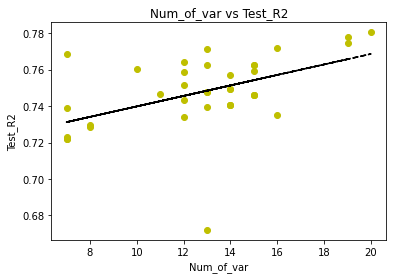

In [ ]:
# plt.plot(df_left['Num_of_var'],df_left['No.of_precip_mom'],'o')
a = 'Num_of_var'
b = 'Test_R2'
x=df_left[a]
y=df_left[b]
coef = np.polyfit(x,y,1)
poly1d_fn = np.poly1d(coef) 
# poly1d_fn is now a function which takes in x and returns an estimate for y
plt.plot(x,y, 'yo', x, poly1d_fn(x), '--k')
plt.title(a+ ' vs ' + b)
plt.xlabel(a)
plt.ylabel(b)

In [ ]:
df3.sort_values(by='%_of_imp_thru_selected_var', ascending=False).head(5).round(2)

,Train_R2,Test_R2,Train_test_%_loss,Num_of_var,%_of_imp_thru_selected_var,No.of_precip_mom,Par_Train_R2,Par_Test_R2,Par_Train_test_%_loss,Var_selected,Imp_scores(corr),G2,bio_15,flowdist_sdev,rockdepth,precip_mean,rr,bio_10,act_bpixelby_area,bio_7,G1,rl,bio_2,act_bpixelinto_precipmean,bio_12,flowdist_mean,slopeoutlet,est_area,bio_4,prod_mean,precip_sdev,bio_3,imperviousbasin,prod_sdev,precip,bio_18,rockvolume,ruggedness,cnbasin,snowpercent,activatedBasinPixels,temp
25,0.75,0.73,3.30,13,0.80,2,0.72,0.72,0.58,"[est_area, rl, act_bpixelinto_precipmean, slop...","[[0.7950061188203661], [0.3403683535768868], [...",1,1,0,0,0,0,1,0,0,1,1,0,1,0,0,1,1,0,1,0,0,0,0,1,0,1,1,0,0,1,0
2,0.80,0.74,6.84,15,0.74,3,0.75,0.73,3.07,"[est_area, rl, slopeoutlet, act_bpixelinto_pre...","[[0.7267704791524904], [0.2746428993014319], [...",1,1,0,0,0,1,1,0,0,1,1,0,1,0,1,1,1,0,1,0,0,0,0,1,0,1,1,0,0,1,0
8,0.83,0.75,9.12,13,0.71,1,0.76,0.74,2.31,"[est_area, rl, act_bpixelinto_precipmean, slop...","[[0.7055251550510113], [0.41364851419359083], ...",1,1,0,0,0,1,1,0,0,1,1,0,1,0,0,1,1,0,0,0,0,0,0,1,0,1,1,0,0,1,0
11,0.83,0.75,9.12,13,0.71,1,0.76,0.74,2.31,"[est_area, rl, act_bpixelinto_precipmean, slop...","[[0.7055251550510113], [0.41364851419359083], ...",1,1,0,0,0,1,1,0,0,1,1,0,1,0,0,1,1,0,0,0,0,0,0,1,0,1,1,0,0,1,0
30,0.85,0.76,10.48,14,0.71,3,0.79,0.75,4.29,"[est_area, rl, act_bpixelinto_precipmean, G1, ...","[[0.6735151010685537], [0.3150033223080658], [...",0,1,0,0,0,1,1,0,0,1,1,0,1,0,1,1,1,0,1,0,0,0,0,1,0,1,1,0,0,1,0


In [ ]:
df3.sort_values(by='No.of_precip_mom', ascending=False).head(5).round(2)

,Train_R2,Test_R2,Train_test_%_loss,Num_of_var,%_of_imp_thru_selected_var,No.of_precip_mom,Par_Train_R2,Par_Test_R2,Par_Train_test_%_loss,Var_selected,Imp_scores(corr),rockdepth,G2,bio_15,flowdist_sdev,precip_mean,rr,bio_10,bio_7,G1,precip_skew,rl,bio_2,act_bpixelinto_precipmean,flowdist_mean,slopeoutlet,est_area,bio_4,prod_mean,precip_sdev,imperviousbasin,prod_sdev,precip,bio_18,rockvolume,ruggedness,cnbasin,snowpercent,activatedBasinPixels,temp
36,0.68,0.67,1.00,13,0.65,5,0.62,0.64,-4.58,"[est_area, activatedBasinPixels, slopeoutlet, ...","[[0.8718322077695904], [0.20323770909036853], ...",0,0,1,0,1,1,0,0,0,1,1,0,1,1,1,1,0,0,0,0,1,0,0,1,1,0,0,1,0
31,0.89,0.76,14.60,15,0.59,5,0.89,0.76,14.44,"[est_area, rl, slopeoutlet, G1, activatedBasin...","[[0.5601362709533945], [0.3317798302978937], [...",0,0,0,0,1,1,1,0,1,0,1,0,1,1,1,1,0,1,0,0,1,1,0,1,1,0,0,1,0
19,0.97,0.77,20.60,16,0.59,5,0.92,0.77,16.27,"[est_area, rl, slopeoutlet, activatedBasinPixe...","[[0.5505049240647445], [0.34366313254716735], ...",0,0,1,0,1,1,1,0,1,0,1,0,1,1,1,1,0,1,0,0,1,1,0,1,1,0,0,1,0
17,0.89,0.76,14.60,15,0.59,5,0.89,0.76,14.44,"[est_area, rl, slopeoutlet, G1, activatedBasin...","[[0.5601362709533945], [0.3317798302978937], [...",0,0,0,0,1,1,1,0,1,0,1,0,1,1,1,1,0,1,0,0,1,1,0,1,1,0,0,1,0
35,0.96,0.78,19.36,19,0.59,5,0.67,0.67,-0.04,"[rl, prod_sdev, bio_10, precip, activatedBasin...","[[0.3960773434172695], [0.28758388166929705], ...",0,0,0,1,0,1,1,1,1,0,1,0,1,1,0,0,1,1,0,1,1,1,1,1,1,0,1,1,1


In [ ]:
main_features_score[0]

,importance
est_area,0.800512
rl,0.338584
slopeoutlet,0.268219
act_bpixelinto_precipmean,0.251245
ruggedness,0.147431
precip,0.133438
rr,0.119276
bio_10,0.091882
rockvolume,0.084743
rockdepth,0.071482


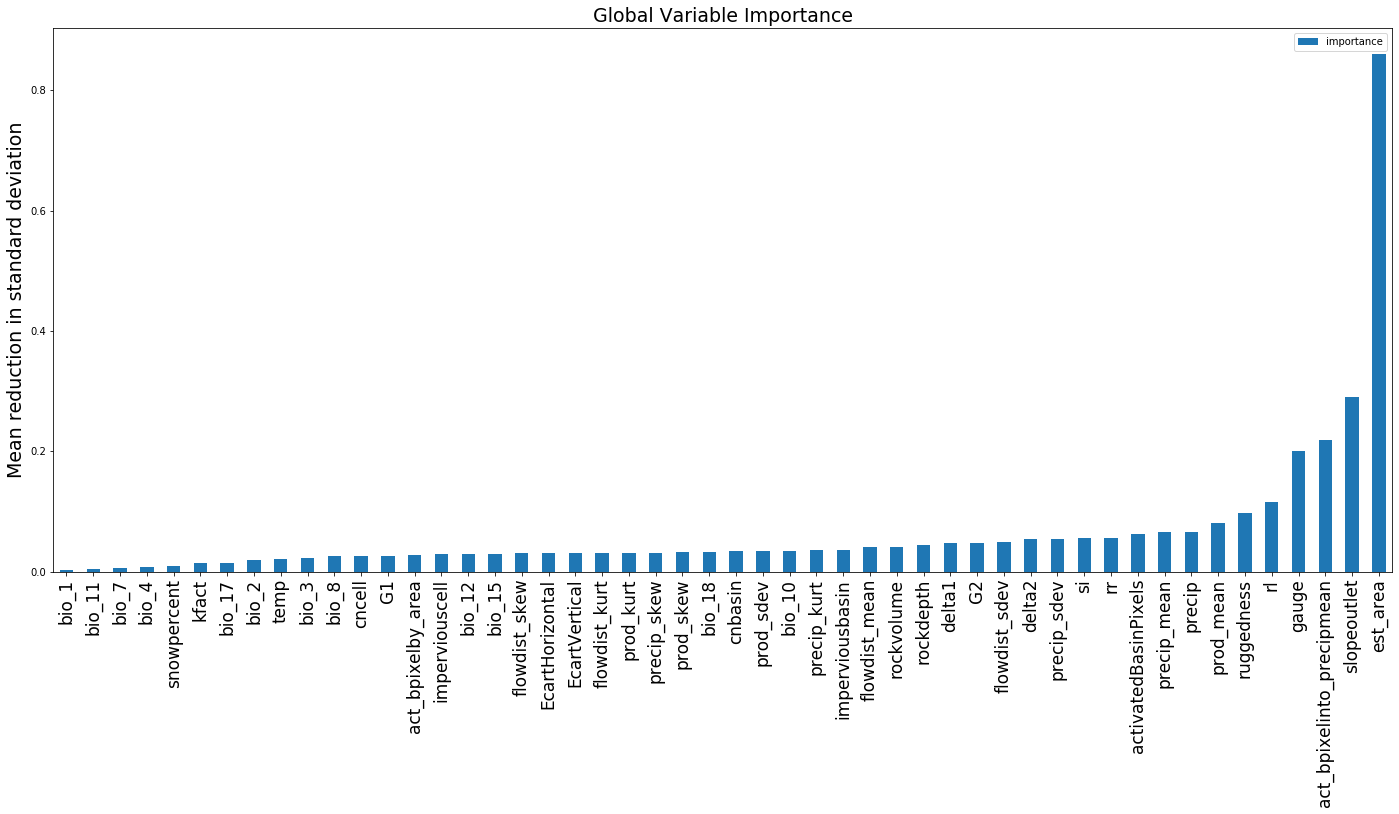

8 selected features are ['gauge', 'est_area', 'rl', 'slopeoutlet', 'precip', 'ruggedness', 'prod_mean', 'act_bpixelinto_precipmean'] 



In [ ]:
train_set = X_train
feature_importances = get_featureimp_xgboost(xg,'total_gain',train_set)
(feature_importances,"Global Variable Importance","Mean reduction in standard deviation")
gain_support = (feature_importances['importance']>(feature_importances['importance'].mean())).values
support_feature = train_set.loc[:,gain_support].columns.tolist()
print(str(len(support_feature)), 'selected features are', support_feature, "\n")

## H2o Xgboost implementation

In [ ]:
# ! pip install h2o
import h2o
from h2o.frame import H2OFrame
from h2o.estimators.random_forest import H2ORandomForestEstimator
from h2o.grid.grid_search import H2OGridSearch
from h2o.estimators import H2OXGBoostEstimator

# Initialize H2O cluster
h2o.init()
h2o.remove_all()
# Transform to H2O Frame, and make sure the target variable is categorical
h2o_df = H2OFrame(df1)
h2o_df.summary()

In [ ]:
# Split into 75% training and 25% test dataset
# strat_split = h2o_df['peakq'].split_frame(test_frac=0.2, seed=42)
train,test,valid = h2o_df.split_frame(ratios=[.7, .15])


# train = h2o_df[strat_split == 'train']
# test = h2o_df[strat_split == 'test']

feature = (h2o_df[:, 0:48]).columns
target = 'peakq'

In [ ]:
xgb = H2OXGBoostEstimator(seed=1234)
xgb.train(x=feature,
                  y=target,
                  training_frame=train,
                  validation_frame=valid)


xgboost Model Build progress: |███████████████████████████████████████████| 100%


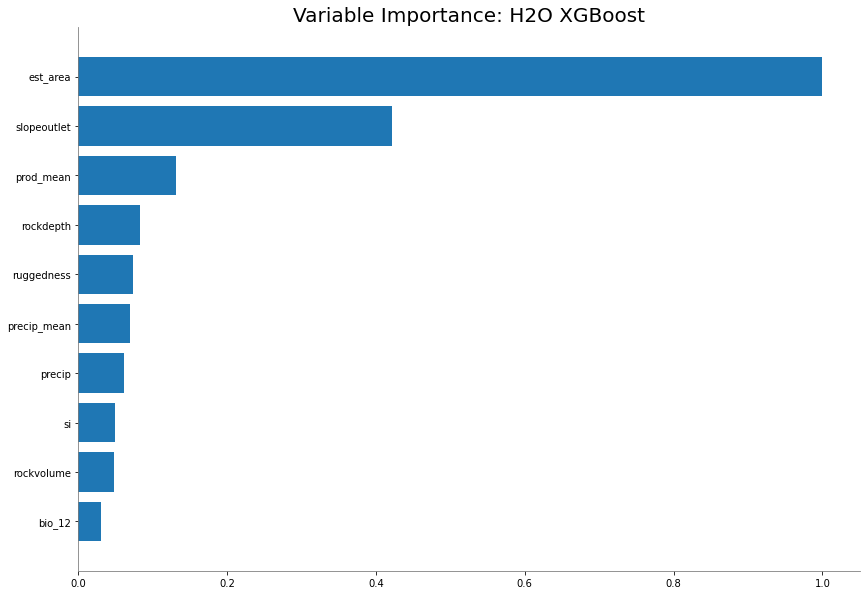

In [ ]:
xgb.varimp_plot()

In [ ]:
feature_importances = xgb.varimp(use_pandas=True)

In [ ]:
gain_support = (feature_importances['percentage']>(feature_importances['percentage'].mean())).values